<h1 align="center">Non-Rigid Registration: Free Form Deformation</h1>

This notebook illustrates the use of the Free Form Deformation (FFD) based non-rigid registration algorithm in SimpleITK.

The data we work with is a 4D (3D+time) thoracic-abdominal CT, the Point-validated Pixel-based Breathing Thorax Model (POPI) model. This data consists of a set of temporal CT volumes, a set of masks segmenting each of the CTs to air/body/lung, and a set of corresponding points across the CT volumes. 

The POPI model is provided by the Léon Bérard Cancer Center & CREATIS Laboratory, Lyon, France. The relevant publication is:

J. Vandemeulebroucke, D. Sarrut, P. Clarysse, "The POPI-model, a point-validated pixel-based breathing thorax model",
Proc. XVth International Conference on the Use of Computers in Radiation Therapy (ICCR), Toronto, Canada, 2007.

The POPI data, and additional 4D CT data sets with reference points are available from the CREATIS Laboratory <a href="http://www.creatis.insa-lyon.fr/rio/popi-model?action=show&redirect=popi">here</a>. 

In [1]:
from __future__ import print_function

import SimpleITK as sitk
import registration_utilities as ru
import registration_callbacks as rc

%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed

#utility method that either downloads data from the Girder repository or
#if already downloaded returns the file name for reading from disk (cached data)
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

## Utilities

Load utilities that are specific to the POPI data, functions for loading ground truth data, display and the labels for masks.

In [2]:
%run popi_utilities_setup.py

## Loading Data

Load all of the images, masks and point data into corresponding lists. If the data is not available locally it will be downloaded from the original remote repository. 

Take a look at the images. According to the documentation on the POPI site, volume number one corresponds to end inspiration (maximal air volume).

In [3]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np

In [6]:
fixed_image = tifffile.imread('/home/manan/Desktop/Manan/BigStitcher/Animal1.tif')
moving_image = tifffile.imread('/home/manan/Desktop/Manan/BigStitcher/Animal2.tif')


(235, 3, 1064, 1064) (178, 1, 532, 532)


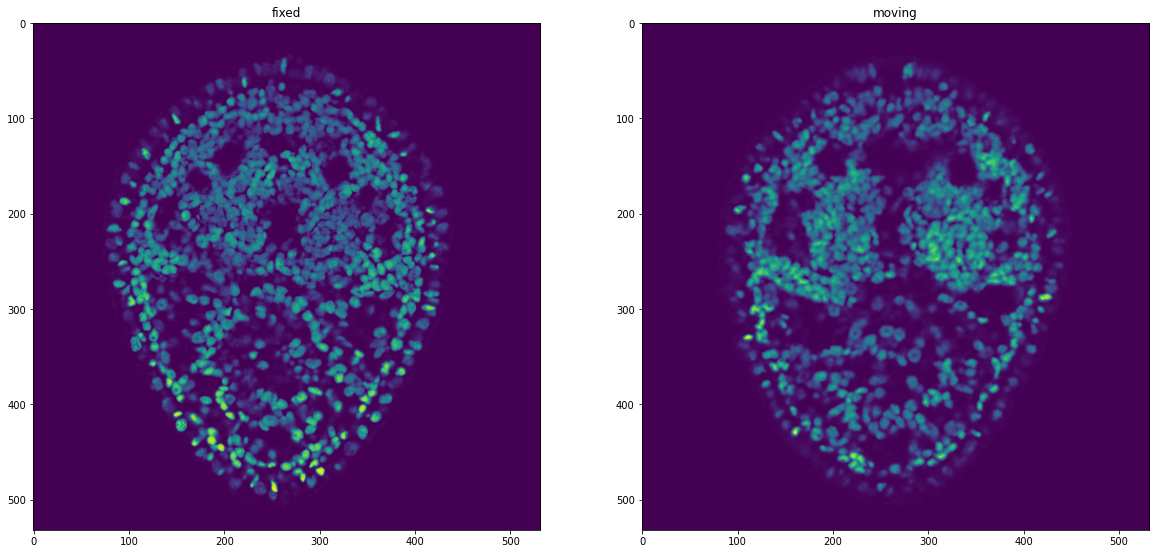

In [5]:
dsFactor=2
fixed_image_c = fixed_image[:, 2, ...][::dsFactor, ::dsFactor, ::dsFactor] # TODO 
#moving_image_c = moving_image[:, 0, ...][::dsFactor, ::dsFactor, ::dsFactor]
moving_image_c = moving_image[:, 0, ...]
plt.figure(figsize= (20, 10))
plt.subplot(1,2,1)
plt.title('fixed')
plt.imshow(fixed_image_c[50, ...])
plt.subplot(1,2,2)
plt.title('moving')
plt.imshow(moving_image_c[50, ...])

In [6]:
print("old fixed image is of shape: ", fixed_image_c.shape)
extendZ = 30
st=np.zeros((extendZ, 532, 532))
end=np.zeros((extendZ, 532, 532))
fixed_image_c=np.concatenate((st, fixed_image_c, end), axis=0)
print("new fixed image is of shape: ", fixed_image_c.shape)
print("old moving image is of shape: ", moving_image_c.shape)
moving_image_c=np.concatenate((st, moving_image_c, end), axis=0)
print("new moving image is of shape: ", moving_image_c.shape)

old fixed image is of shape:  (118, 532, 532)
new fixed image is of shape:  (178, 532, 532)
old moving image is of shape:  (140, 532, 532)
new moving image is of shape:  (200, 532, 532)


In [7]:
mean_moving=np.mean(moving_image_c)
std_moving=np.std(moving_image_c)

mean_fixed=np.mean(fixed_image_c)
std_fixed=np.std(fixed_image_c)

moving_image_c_norm = (moving_image_c - mean_moving)/(std_moving)
fixed_image_c_norm = (fixed_image_c - mean_fixed)/(std_fixed)

min moving -0.32802573908741633 max moving 16.930849514232047
min fixed -0.3315104104341715 max fixed 36.84584977479035


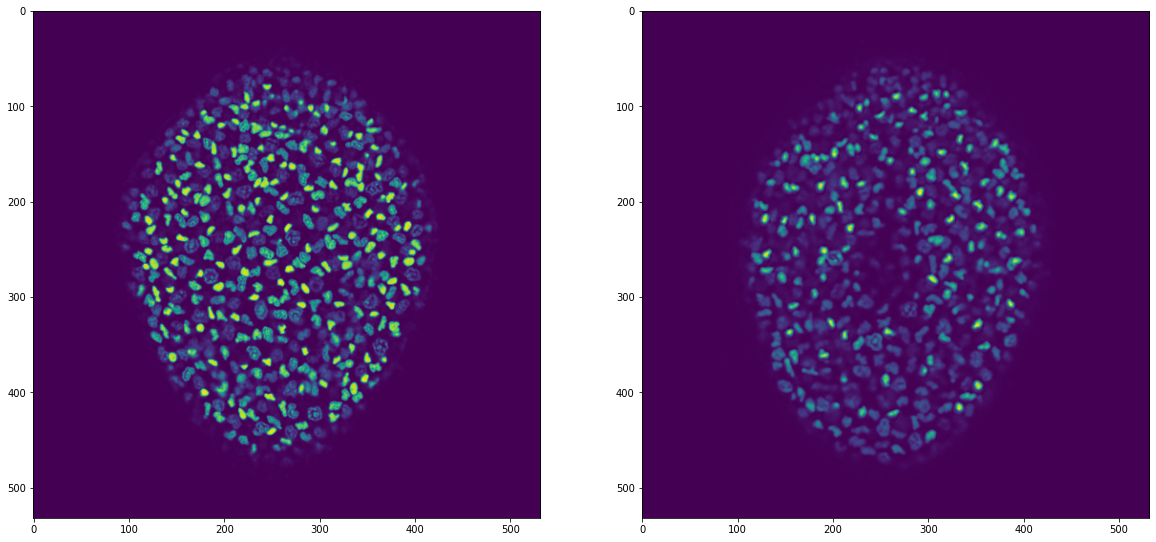

In [8]:
plt.figure(figsize= (20, 10))
plt.subplot(1,2,1)
plt.imshow(fixed_image_c_norm[50, ...])
plt.subplot(1,2,2)
plt.imshow(moving_image_c_norm[50, ...])
print("min moving", np.min(moving_image_c_norm), "max moving", np.max(moving_image_c_norm))
print("min fixed", np.min(fixed_image_c_norm), "max fixed", np.max(fixed_image_c_norm))

In [9]:
#points1=pd.read_csv('/home/manan/Desktop/Manan/BigStitcher/RegLandmarksJohannes/Animal1.csv', usecols=[5, 6, 8])
#points1['X']  #TODO

In [10]:
import pandas as pd
points1=pd.read_csv('/home/manan/Desktop/Manan/BigStitcher/RegLandmarksJohannes/Animal1.csv', usecols=[5, 6, 8])
points1 = points1.to_numpy()
points2=pd.read_csv('/home/manan/Desktop/Manan/BigStitcher/RegLandmarksJohannes/Animal2.csv', usecols=[5, 6, 8])
points2 = points2.to_numpy()
print(points1)
print(points2)


[[ 87.004  59.842 102.   ]
 [ 73.317  69.497 101.   ]
 [134.645  65.041 101.   ]
 [148.226  76.712 101.   ]
 [108.543  83.927 117.   ]
 [100.48   81.381  94.   ]
 [121.276  81.169  94.   ]
 [ 97.509  91.355  94.   ]
 [122.761  93.901  94.   ]
 [ 53.794 102.389  94.   ]
 [161.595 109.604  94.   ]
 [101.965  74.166 175.   ]
 [114.273  76.925 175.   ]]
[[ 85.731  60.267  41.   ]
 [ 72.468  78.198  41.   ]
 [142.496  64.617  41.   ]
 [156.29   73.529  41.   ]
 [114.273  87.535  52.   ]
 [ 98.994  83.927  37.   ]
 [119.79   87.747  37.   ]
 [ 97.296 100.692  36.   ]
 [124.459  99.419  36.   ]
 [ 58.463 113.424  37.   ]
 [166.9   108.543  37.   ]
 [102.814  78.41   76.   ]
 [120.639  75.015  68.   ]]


In [12]:
## downsample landmarks

points1=points1/dsFactor 
points2=points2/dsFactor

## add extendZ
points1[:, 2] = points1[:, 2] + extendZ
points2[:, 2] = points2[:, 2] + extendZ

## (XYZ) --> (ZYX)
points1 = np.flip(points1, 1)
points2 = np.flip(points2, 1)

print(points1)
print(points2)


[[51.751   14.9605  40.5    ]
 [48.32925 17.37425 40.25   ]
 [63.66125 16.26025 40.25   ]
 [67.0565  19.178   40.25   ]
 [57.13575 20.98175 44.25   ]
 [55.12    20.34525 38.5    ]
 [60.319   20.29225 38.5    ]
 [54.37725 22.83875 38.5    ]
 [60.69025 23.47525 38.5    ]
 [43.4485  25.59725 38.5    ]
 [70.39875 27.401   38.5    ]
 [55.49125 18.5415  58.75   ]
 [58.56825 19.23125 58.75   ]]
[[51.43275 15.06675 25.25   ]
 [48.117   19.5495  25.25   ]
 [65.624   16.15425 25.25   ]
 [69.0725  18.38225 25.25   ]
 [58.56825 21.88375 28.     ]
 [54.7485  20.98175 24.25   ]
 [59.9475  21.93675 24.25   ]
 [54.324   25.173   24.     ]
 [61.11475 24.85475 24.     ]
 [44.61575 28.356   24.25   ]
 [71.725   27.13575 24.25   ]
 [55.7035  19.6025  34.     ]
 [60.15975 18.75375 32.     ]]


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [17]:
images = []
#masks = []
points = []

fixed_image = sitk.GetImageFromArray(fixed_image_c_norm)
moving_image = sitk.GetImageFromArray(moving_image_c_norm)

images.append(fixed_image)
images.append(moving_image)
for i in range(2):
    points_file_name = 'POPI/landmarks/{0}0-Landmarks.pts'.format(i)
    points.append(read_POPI_points(fdata(points_file_name)))

#points.append([points1]) #TODO
#points.append([points2]) #TODO





# for i in range(0,10):
#     image_file_name = 'POPI/meta/{0}0-P.mhd'.format(i)
#     mask_file_name = 'POPI/masks/{0}0-air-body-lungs.mhd'.format(i)
#     points_file_name = 'POPI/landmarks/{0}0-Landmarks.pts'.format(i)
#     images.append(sitk.ReadImage(fdata(image_file_name), sitk.sitkFloat32)) #read and cast to format required for registration
#     masks.append(sitk.ReadImage(fdata(mask_file_name)))
#     points.append(read_POPI_points(fdata(points_file_name)))
  
# TODO !!!    
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

# interact(display_coronal_with_overlay, temporal_slice=(0,len(images)-1), 
#          coronal_slice = (0, images[0].GetSize()[1]-1), 
#          images = fixed(images), masks = fixed(images), 
#          label=fixed(lung_label), window_min = fixed(-1024), window_max=fixed(976));

Fetching POPI/landmarks/00-Landmarks.pts
Fetching POPI/landmarks/10-Landmarks.pts


interactive(children=(IntSlider(value=88, description='fixed_image_z', max=177), IntSlider(value=99, descripti…

In [19]:
len(points[0])

41

### Getting to know your data

While the POPI site states that image number 1 is end inspiration, and visual inspection seems to suggest this is correct, we should probably take a look at the lung volumes to ensure that what we expect is indeed what is happening.

Which image is end inspiration and which end expiration?

In [14]:
# label_shape_statistics_filter = sitk.LabelShapeStatisticsImageFilter()

# for i, mask in enumerate(masks):
#     label_shape_statistics_filter.Execute(mask)
#     print('Lung volume in image {0} is {1} liters.'.format(i,0.000001*label_shape_statistics_filter.GetPhysicalSize(lung_label)))

## Free Form Deformation

This function will align the fixed and moving images using a FFD. If given a mask, the similarity metric will be evaluated using points sampled inside the mask. If given fixed and moving points the similarity metric value and the target registration errors will be displayed during registration. 

As this notebook performs intra-modal registration, we use the MeanSquares similarity metric (simple to compute and appropriate for the task).

In [20]:
def bspline_intra_modal_registration(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    grid_physical_spacing = [50.0, 50.0, 50.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, 
                                                         transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)
        
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be 
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
    

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))
    
    return registration_method.Execute(fixed_image, moving_image)

## Perform Registration

The following cell allows you to select the images used for registration, runs the registration, and afterwards computes statistics comparing the target registration errors before and after registration and displays a histogram of the TREs.

To time the registration, uncomment the timeit magic. 
<b>Note</b>: this creates a separate scope for the cell. Variables set inside the cell, specifically tx, will become local variables and thus their value is not available in other cells. 

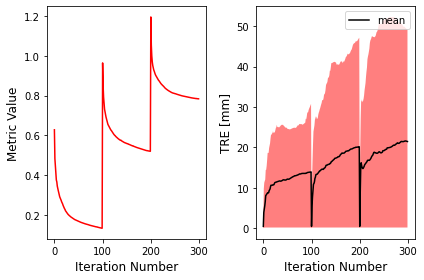

Initial alignment errors in millimeters, mean(std): 0.47(0.53), max: 2.36
Final alignment errors in millimeters, mean(std): 21.45(12.42), max: 49.24


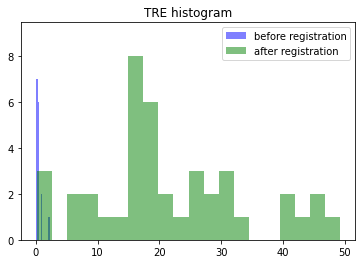

In [21]:
#%%timeit -r1 -n1


# Select the fixed and moving images, valid entries are in [0,1].
fixed_image_index = 0
moving_image_index = 1

tx = bspline_intra_modal_registration(fixed_image = images[fixed_image_index], 
                                      moving_image = images[moving_image_index],
                                      fixed_image_mask = None,
                                      fixed_points = points[fixed_image_index], 
                                      moving_points = points[moving_image_index]
                                     )

# tx = bspline_intra_modal_registration(fixed_image = images[fixed_image_index], 
#                                       moving_image = images[moving_image_index],
#                                       fixed_image_mask = (masks[fixed_image_index] == lung_label),
#                                       fixed_points = points[fixed_image_index], 
#                                       moving_points = points[moving_image_index]
#                                      )
initial_errors_mean, initial_errors_std, _, initial_errors_max, initial_errors = ru.registration_errors(sitk.Euler3DTransform(), points[fixed_image_index], points[moving_image_index])
final_errors_mean, final_errors_std, _, final_errors_max, final_errors = ru.registration_errors(tx, points[fixed_image_index], points[moving_image_index])

plt.hist(initial_errors, bins=20, alpha=0.5, label='before registration', color='blue')
plt.hist(final_errors, bins=20, alpha=0.5, label='after registration', color='green')
plt.legend()
plt.title('TRE histogram');
print('Initial alignment errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(initial_errors_mean, initial_errors_std, initial_errors_max))
print('Final alignment errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(final_errors_mean, final_errors_std, final_errors_max))

Another option for evaluating the registration is to use segmentation. In this case, we transfer the segmentation from one image to the other and compare the overlaps, both visually, and quantitatively.

<b>Note</b>: A more detailed version of the approach described here can be found in the [Segmentation Evaluation notebook](34_Segmentation_Evaluation.ipynb).

In [22]:
moving_resampled = sitk.Resample(moving_image, fixed_image, tx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=88, description='image_z', max=177), FloatSlider(value=0.5, description=…

In [24]:
OUTPUT_DIR='/home/manan/Desktop/'
# save transformed animal 2 (transformed & normalised)
moving_resampled_array=sitk.GetArrayFromImage(moving_resampled)


In [25]:
# save transformed animal 2 (de normalised)
moving_resampled_array_denorm=moving_resampled_array*std_moving + mean_moving
tifffile.imsave(OUTPUT_DIR+'animal2_transformed_denorm.tif', moving_resampled_array_denorm.astype(np.uint16))

In [26]:
# save animal 1 (de normalised)
target_array= sitk.GetArrayFromImage(fixed_image)
target_array_denorm=target_array*std_fixed + mean_fixed

tifffile.imsave(OUTPUT_DIR+'animal1_denorm.tif', target_array_denorm.astype(np.uint16))

In [25]:
# Transfer the segmentation via the estimated transformation. Use Nearest Neighbor interpolation to retain the labels.
transformed_labels = sitk.Resample(masks[moving_image_index],
                                   images[fixed_image_index],
                                   tx, 
                                   sitk.sitkNearestNeighbor,
                                   0.0, 
                                   masks[moving_image_index].GetPixelID())

segmentations_before_and_after = [masks[moving_image_index], transformed_labels]
interact(display_coronal_with_label_maps_overlay, coronal_slice = (0, images[0].GetSize()[1]-1),
         mask_index=(0,len(segmentations_before_and_after)-1),
         image = fixed(images[fixed_image_index]), masks = fixed(segmentations_before_and_after), 
         label=fixed(lung_label), window_min = fixed(-1024), window_max=fixed(976));

# Compute the Dice coefficient and Hausdorff distance between the segmentations before, and after registration.
ground_truth = masks[fixed_image_index] == lung_label
before_registration = masks[moving_image_index] == lung_label
after_registration = transformed_labels == lung_label

label_overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
label_overlap_measures_filter.Execute(ground_truth, before_registration)
print("Dice coefficient before registration: {:.2f}".format(label_overlap_measures_filter.GetDiceCoefficient()))
label_overlap_measures_filter.Execute(ground_truth, after_registration)
print("Dice coefficient after registration: {:.2f}".format(label_overlap_measures_filter.GetDiceCoefficient()))

hausdorff_distance_image_filter = sitk.HausdorffDistanceImageFilter()
hausdorff_distance_image_filter.Execute(ground_truth, before_registration)
print("Hausdorff distance before registration: {:.2f}".format(hausdorff_distance_image_filter.GetHausdorffDistance()))
hausdorff_distance_image_filter.Execute(ground_truth, after_registration)
print("Hausdorff distance after registration: {:.2f}".format(hausdorff_distance_image_filter.GetHausdorffDistance()))

interactive(children=(IntSlider(value=179, description='coronal_slice', max=359), IntSlider(value=0, descripti…

Dice coefficient before registration: 0.94
Dice coefficient after registration: 0.97
Hausdorff distance before registration: 18.04
Hausdorff distance after registration: 13.95


## Multi-resolution control point grid

In the example above we used the standard image registration framework. This implies the same transformation model at all image resolutions. For global transformations (e.g. rigid, affine...) the number of transformation parameters has no relationship to the changing resolution. For the BSpline transformation we can potentially use fewer control points for images with lower frequencies, higher levels of the image pyramid, increasing the number of control points as we go down the pyramid. With the standard framework we use the same number of control points for all pyramid levels.

To use a multi-resolution control point grid we have a specific initializer for the BSpline transformation, [SetInitialTransformAsBSpline](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ImageRegistrationMethod.html#ada2d2f32fda2b2aa70f8ddfe40bfd74d).

The following code solves the same registration task as above, just with a multi-resolution control point grid.

In [26]:
def bspline_intra_modal_registration2(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we 
    # want for the finest resolution control grid. 
    grid_physical_spacing = [50.0, 50.0, 50.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    # The starting mesh size will be 1/4 of the original, it will be refined by 
    # the multi-resolution framework.
    mesh_size = [int(sz/4 + 0.5) for sz in mesh_size]
    
    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, 
                                                         transformDomainMeshSize = mesh_size, order=3)    
    # Instead of the standard SetInitialTransform we use the BSpline specific method which also
    # accepts the scaleFactors parameter to refine the BSpline mesh. In this case we start with 
    # the given mesh_size at the highest pyramid level then we double it in the next lower level and
    # in the full resolution image we use a mesh that is four times the original size.
    registration_method.SetInitialTransformAsBSpline(initial_transform,
                                                     inPlace=True,
                                                     scaleFactors=[1,2,4])
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be 
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    # Use the LBFGS2 instead of LBFGS. The latter cannot adapt to the changing control grid resolution.
    registration_method.SetOptimizerAsLBFGS2(solutionAccuracy=1e-2, numberOfIterations=100, deltaConvergenceTolerance=0.01)

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))
    
    return registration_method.Execute(fixed_image, moving_image)

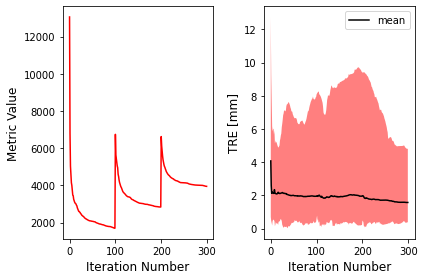

Initial alignment errors in millimeters, mean(std): 5.07(2.67), max: 14.02
Final alignment errors in millimeters, mean(std): 1.58(0.83), max: 4.82


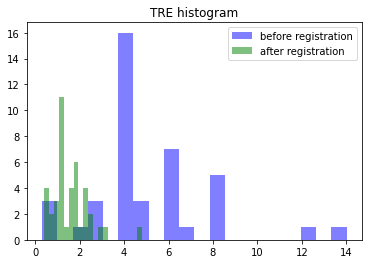

In [27]:
#%%timeit -r1 -n1

# Select the fixed and moving images, valid entries are in [0,9].
fixed_image_index = 0
moving_image_index = 7


tx = bspline_intra_modal_registration2(fixed_image = images[fixed_image_index], 
                                      moving_image = images[moving_image_index],
                                      fixed_image_mask = (masks[fixed_image_index] == lung_label),
                                      fixed_points = points[fixed_image_index], 
                                      moving_points = points[moving_image_index]
                                     )
initial_errors_mean, initial_errors_std, _, initial_errors_max, initial_errors = ru.registration_errors(sitk.Euler3DTransform(), points[fixed_image_index], points[moving_image_index])
final_errors_mean, final_errors_std, _, final_errors_max, final_errors = ru.registration_errors(tx, points[fixed_image_index], points[moving_image_index])

plt.hist(initial_errors, bins=20, alpha=0.5, label='before registration', color='blue')
plt.hist(final_errors, bins=20, alpha=0.5, label='after registration', color='green')
plt.legend()
plt.title('TRE histogram');
print('Initial alignment errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(initial_errors_mean, initial_errors_std, initial_errors_max))
print('Final alignment errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(final_errors_mean, final_errors_std, final_errors_max))